# Feature Extraction

Flow aggregation by a time window

Generated features:
* NumSrcPorts
* NumDestAddr
* NumDestPorts
* NumFlows
* NumBytesSum
* NumBytesMean
* NumBytesVar
* NumPacketsSum
* NumPacketsMean
* NumPacketsVar

## Imports

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import glob
import time

import warnings

import matplotlib.pyplot as plt
import itertools

import pickle

warnings.filterwarnings("ignore")

## Functions

In [ ]:
features = ["NumSrcPorts", "NumDestAddr", "NumDestPorts", "NumFlows",
                   "NumBytesSum", "NumBytesMean", "NumBytesVar",
                   "NumPacketsSum", "NumPacketsMean", "NumPacketsVar"]

def extract_features(input_df):
    # Take only the botnet part
    df_botnet = input_df[input_df['Label'].str.contains("flow=From-Botnet")]
    df_botnet.loc[:, "StartTime"] = pd.to_datetime(df_botnet.StartTime, format='%Y/%m/%d %H:%M:%S.%f')
    df_botnet.sort_values(by=['StartTime'], inplace=True)
    df_botnet.reset_index(drop=True, inplace=True)
#     df_botnet.head()
    
    
    # Determine the time windows
    time_windows = [0]
    for i in range(1, len(df_botnet)):
        # Find the optimal time window duration
        if (df_botnet["StartTime"][i] - df_botnet["StartTime"][time_windows[-1]]).seconds > 30:
            time_windows.append(i)

    time_windows.append(len(df_botnet)) # Added it for easier indexing             
    
    
    # Determined column keys
    column_keys = ["NumSrcPorts", "NumDestAddr", "NumDestPorts", "NumFlows",
                   "NumBytesSum", "NumBytesMean", "NumBytesVar",
                   "NumPacketsSum", "NumPacketsMean", "NumPacketsVar"]
    gen_df = pd.DataFrame(None, columns=column_keys)

    # Generate the features for each time window
    for i in range(len(time_windows)-1):
        current_df = df_botnet.iloc[time_windows[i]:time_windows[i+1],:]

        group = current_df.groupby("SrcAddr")

        for address, addr_df in group:
            # TODO: Optionally source ip address can be added
#             print(address)

            num_src_ports = len(addr_df.Sport.unique())

            num_dest_addr = len(addr_df.DstAddr.unique())

            num_dest_ports = len(addr_df.Dport.unique())

            num_flows = len(addr_df)

            # TODO: SrcBytes or TotBytes?
            num_bytes_sum = np.sum(addr_df.SrcBytes)
            
            num_bytes_mean = np.mean(addr_df.SrcBytes)
            
            num_bytes_var = np.var(addr_df.SrcBytes)

            num_packets_sum = np.sum(addr_df.TotPkts)
            
            num_packets_mean = np.mean(addr_df.TotPkts)
            
            num_packets_var = np.var(addr_df.TotPkts)
            
            
            

            curr_gen_df = pd.DataFrame([[num_src_ports, num_dest_addr, num_dest_ports, num_flows,
                                         num_bytes_sum, num_bytes_mean, num_bytes_var, num_packets_sum,
                                         num_packets_mean, num_packets_var]], columns=column_keys)
            gen_df = gen_df.append(curr_gen_df, ignore_index=True)
            
    return gen_df


def extract_features_all(data_path):
    scenario_list = os.listdir(data_path)
    print(scenario_list)

    feat_list = []
    
    for scenario in scenario_list:
        scenario_path = os.path.join(data_path, scenario)
        
        if os.path.isdir(scenario_path):
            print(scenario)
            flow_file_path = glob.glob(os.path.join(scenario_path, "*.binetflow"))[0]
            
            # Extract features for the current scenario
            input_df = pd.read_csv(flow_file_path)
            scenario_features = extract_features(input_df)
            
            # Append scenario label
            scenario_features.loc[:, "Scenario"] = int(scenario)
            
            p_filename = "botnet_cache/botnet_scenario_features_"+str(scenario)+".p"
            pickle.dump( scenario_features, open( p_filename, "wb" ) )
            
            feat_list.append(scenario_features)
           
    pickle.dump( feat_list, open( "botnet_cache/botnet_feat_list.p", "wb" ) )
    return pd.concat(feat_list)

## Extract Features

In [9]:
DATA_PATH = os.path.join("..", "Project\ctu-13")

start_time = time.time()
gen_feat_df = extract_features_all(DATA_PATH)

print("--- %s seconds ---" % (time.time() - start_time))
gen_feat_df.head()

['1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']
1
10
11
12
13
2
3
4
5
6
7
8
9
--- 128.11381793022156 seconds ---


,NumSrcPorts,NumDestAddr,NumDestPorts,NumFlows,NumBytesSum,NumBytesMean,NumBytesVar,NumPacketsSum,NumPacketsMean,NumPacketsVar,Scenario
0,2,2,2,3,780,260.000000,6.816867e+04,11,3.666667,5.555556,1
1,10,7,6,18,15072,837.333333,1.075430e+06,510,28.333333,1910.444444,1
2,22,18,6,24,20881,870.041667,3.699151e+06,659,27.458333,6182.414931,1
3,13,13,4,13,2771,213.153846,1.712798e+04,47,3.615385,3.159763,1
4,16,15,4,16,7261,453.812500,6.050515e+05,183,11.437500,865.246094,1


## Visualization

In [146]:
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

color = sns.color_palette()
sns.set_style("dark")
%matplotlib inline

In [149]:
means_vars = []
for i in range(1,14):
    means_vars.append(gen_feat_df_fl[gen_feat_df_fl['Scenario'] == i].describe().loc[['mean', 'std']])

means_vars_df = pd.concat(means_vars)
means_vars_df

,NumSrcPorts,NumDestAddr,NumDestPorts,NumFlows,NumBytes,NumBytesMean,NumBytesVar,NumPackets,NumPacketsMean,NumPacketsVar,Scenario
mean,22.589454,33.450094,4.779661,77.139360,2.685365e+04,6.784609e+02,7.064053e+07,380.090395,9.323926,2.851382e+04,1.0
std,7.411936,38.016963,1.368941,124.976358,5.931275e+04,1.821151e+03,3.171391e+08,973.331644,39.915215,2.708003e+05,0.0
mean,54.052778,23.491667,5.097222,58.169444,3.635255e+04,7.445359e+02,5.361828e+07,493.688889,9.455869,2.267793e+04,2.0
std,129.991686,6.143587,1.458428,130.284354,6.181034e+04,1.214393e+03,2.264445e+08,1254.851540,24.033736,1.953021e+05,0.0
mean,15.976148,15.977937,1.011926,15.994037,3.153422e+03,3.345691e+02,3.202355e+02,56.407275,6.561144,7.773936e-01,3.0
std,5.017098,5.018473,0.157852,5.016199,9.461887e+02,8.036294e+02,5.231185e+03,26.822194,18.845573,5.496321e+00,0.0
mean,14.207407,7.733333,3.259259,19.111111,3.698307e+05,8.540942e+04,2.833019e+12,331.044444,69.957302,1.709839e+06,4.0
std,16.619130,8.695684,3.909352,15.282253,3.894014e+06,9.716335e+05,3.290964e+13,3026.955576,754.515887,1.985307e+07,0.0
mean,25.085714,9.571429,4.571429,25.742857,2.822840e+05,8.709310e+03,1.860435e+09,896.342857,29.674918,4.366912e+03,5.0
std,14.000780,4.354077,1.460977,14.011220,4.319332e+05,1.210316e+04,4.585609e+09,1069.576000,28.407258,9.864252e+03,0.0


In [266]:
gen_feat_df_fl = gen_feat_df.astype(float)
gen_feat_s_df_fl = gen_feat_s_df.astype(float)

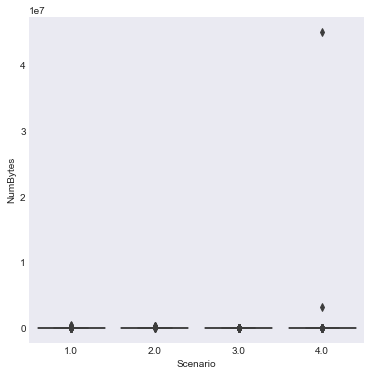

In [252]:
plt.figure(figsize=(6,6))
sns.boxplot(y='NumBytes',x='Scenario', data=gen_feat_df_fl[gen_feat_df_fl['Scenario']<5])
plt.show()